In [1]:
from SurfaceQ import *
import matplotlib.pyplot as plt

The main class that the python module SurfaceQ defines is the ```RotatedSurfaceCode``` class. Calling the constructor defines a rotated surface code of size $k_{0} \times k_{1}$, initialized to a logical state (as an optional parameter). If no logical state is given, the code is initialized to logical zero (i.e. the ground state of the code system). 


In [2]:
surfacecode = RotatedSurfaceCode(9,9)

To visualize the rotated surface code, the ```RotatedSurfaceCode``` class has a draw function, which is essentially a wrapper for the draw function provided by NetworkX. We can pass in a "mode parameter", which can be "primal", "X" or "Z". If  ```mode = 'primal' ```, then NetworkX will draw the primal lattice of the surface code, if ```mode = 'X' ``` or ``` mode = 'Z' ```, then NetworkX will draw the corresponding Tanner graph (i.e. the Tanner graph corresponding to $X$ checks or the Tanner graph corresponding to $Z$ checks). Furthermore, there is an optional ```coords``` parameter: if we set ```coords = 'flat' ```, then the data nodes will be labelled by their index with respect to dictionary ordering of the lattice node coordinates. This is also the ordering that qubit registers are added onto the quantum circuit initializing the surface code. If we do not specify this parameter, then the data nodes are given by the lattice coordinates of the nodes in the primal lattice. 

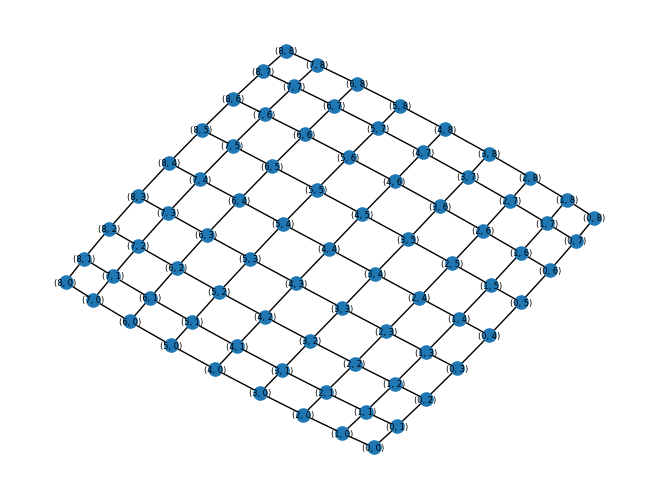

In [3]:
surfacecode.draw( 'primal' )

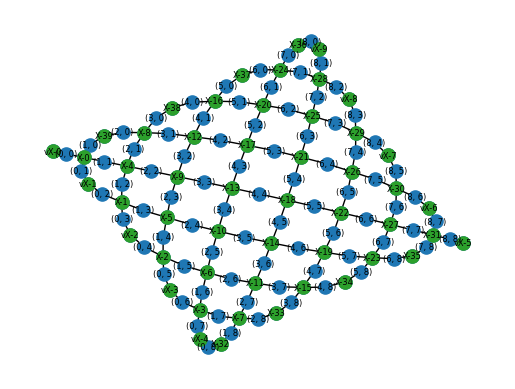

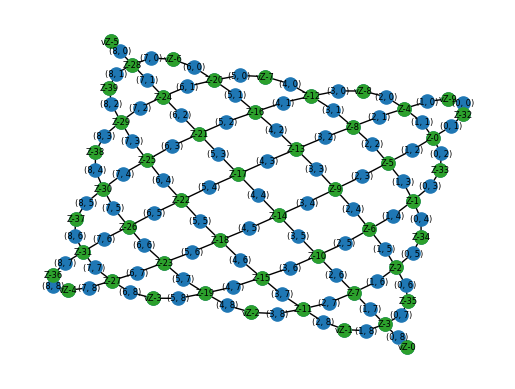

In [4]:
surfacecode.draw('X')
plt.pause(1)
surfacecode.draw('Z')


Let us breakdown the Union-Find decoding algorithm and illustrate some of the steps involved.

First, we run the surface code through a simulated depolarizing channel. We can turn on a ```report option``` parameter to print out the affected qubits.  Below, we will simulate a 10% physical error rate.



In [5]:
depolarizing_channel(surfacecode.LatticeCircuit, surfacecode.DataQubits, 0.10, print_option=True)

Z on <Qubit register=(1, "(3, 0)"), index=0>
Y on <Qubit register=(1, "(3, 8)"), index=0>
Z on <Qubit register=(1, "(4, 0)"), index=0>
Y on <Qubit register=(1, "(4, 2)"), index=0>
X on <Qubit register=(1, "(5, 6)"), index=0>
X on <Qubit register=(1, "(5, 7)"), index=0>
Z on <Qubit register=(1, "(7, 0)"), index=0>
Z on <Qubit register=(1, "(8, 4)"), index=0>


Next, we measure syndromes and record the positions of the ancilla qubits in excitation

In [6]:
label = 'X'
surfacecode.syndrome_measurement('X') 
job = AerSimulator().run(surfacecode.LatticeCircuit, shots=1, memory=True)       
result = job.result()
memory = result.get_memory(surfacecode.LatticeCircuit)
memory_result = memory_result = memory[0].replace(' ','')[len(surfacecode.X_plaquettes)+1: ][::-1]

positions = []
for i in range(len(memory_result)):
    if memory_result[i] == '1':
        positions.append('X-' + str(i) )

In [7]:
print( positions )

['X-8', 'X-12', 'X-15', 'X-16', 'X-17', 'X-24', 'X-29', 'X-33', 'X-36']


In [8]:
tanner_graph = surfacecode.tanner_graphs[label]
virtual_checks = surfacecode.X_virtual_checks if label == 'X' else surfacecode.Z_virtual_checks
Clusters = { node : Cluster(node , tanner_graph, parity = int(node in positions), active = ( node not in virtual_checks ) ) for node in positions }  

node_table = {key: { 'nodes': [], 'visits': 0 }  for key in tanner_graph.nodes }
for root in Clusters:
    node_table[root]['nodes'].append(root)
    node_table[root]['visits'] = 1

Cluster_forest = nx.DiGraph()
Cluster_forest.add_nodes_from( positions )

active_odd_cluters = [ cluster for cluster in Clusters if Clusters[cluster].parity == 1 and Clusters[cluster].active  ]
phase = 0 

Then, the Union-Find algorithm goes through a "growth phase", followed by a "fusion phase"

In [9]:
phase = phase%2
for root in active_odd_cluters:

    Clusters[root].grow(phase)
    for v in Clusters[root].boundary:
        if root not in node_table[v]['nodes']:
            node_table[v]['nodes'].append(root)
            node_table[v]['visits'] += 1 

    if phase == 1:
        if (set(Clusters[root].boundary) & set(virtual_checks)):
            Clusters[root].active = False  
    Cluster_forest.update(Clusters[root ].graph)

fusion_table = { key: node_table[key]['nodes'] for key in node_table if len(node_table[key]['nodes']) >= 2  }

In [10]:
while fusion_table:
### fusion phase
    for key in list(fusion_table.keys()):
        
        item_1 = node_table[key]['nodes'].pop(0)
        item_2 = node_table[key]['nodes'].pop(0)
        root_1 = find_root(Cluster_forest, item_1 )
        root_2 = find_root(Cluster_forest, item_2 )  
        ordered = sorted( [ ( Clusters[root_1].size, root_1),  ( Clusters[root_2].size, root_2) ] )[::-1]

        if root_1 != root_2:
            Clusters[ordered[0][1] ].union( Clusters[ordered[1][1]], key )
            Cluster_forest.update( Clusters[ordered[0][1]].graph )

        node_table[key]['nodes'].append( ordered[0][1] ) 

    fusion_table = { key: node_table[key]['nodes'] for key in node_table if len(node_table[key]['nodes']) >= 2 }

phase += 1 
active_odd_cluters = [ cluster for cluster in Clusters if Clusters[cluster].parity == 1 and Clusters[cluster].active  ]

At the end of these phases, we can visualize the growing clusters on the corresponding Tanner graph:

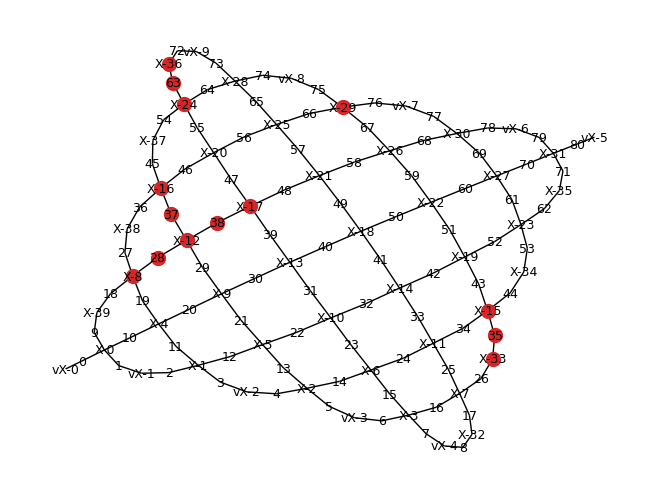

In [11]:
total_nodes = list(Cluster_forest.nodes) + list(itertools.chain(*[ Clusters[root].edge_nodes for root in Clusters  ]) )
nx.draw(tanner_graph, pos=nx.spring_layout(tanner_graph, iterations=1000), nodelist= total_nodes, node_color='tab:red',  with_labels=True,font_size=9,node_size=100  )

Repeating cells [9], [10] and [11] consecutively, until ```active_odd_cluters``` is empty will give a visualization of the end of the syndrome validation phase of the Union-Find decoding algorithm. That is, the clusters are all finished growing (and fusing) -- the remaining clusters may each be considered as erasure errors and may be passed into the erasure decoder (i.e. the peeling decoder).

Running ```RotatedSurfaceCode.single_round(p_error, error_type, decoder_option)``` with ```decoder_option = union-find``` will run a full cycle of error channel -> syndrome measurement -> Union-Find decoding -> measure final logical state. The Jupyter notebook [SurfaceQdemo2.ipynb](SurfaceQdemo2.ipynb) demonstrates some bulk error cycle simulations and records some success rate statistics for respective decoders.